# Figure 2

#### Plot observations of processes and highly correlated channels from AIRS

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define functions for computing trends and correlations

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [2]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [3]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [4]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

In [5]:
def calculate_spatial_correlation(cntl,test):
    """
    Calculate the spatial correlation coefficient for two xarray dataarrays, weighting by gridcell area.
    Values marked with a Nan are mutually masked.
    """
    
    _cntl = add_weights(cntl)
       
    mask = np.bitwise_or(xr.ufuncs.isnan(cntl),xr.ufuncs.isnan(test)) # mask means hide
    
    wgt = np.array(_cntl['cell_weight'])
    wgt = np.where(~mask,wgt,np.nan) # erroring
    
    sumwgt = np.nansum(wgt)
        
    # calculate means
    meantest = np.nansum(wgt*test)/sumwgt
    meancntl = np.nansum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.nansum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.nansum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.nansum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem
    
    return corr

## Load observations

### Load AIRS spectral trends

These were initially processed in the AIRS_channel_selection notebook.

In [6]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'

In [7]:
all_data_spec_olr = xr.open_dataset('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))
all_data_spec_olr_clr = xr.open_dataset('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))

### Loads AIRS temperature and water vapor retrievals

#### Create function to average over the ascending and descending orbits

In [8]:
def average_AIRS_orbits(var,tseries_dir='/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'):
    
    ascending_file = glob.glob('%s/*%s_A.*.nc' % (tseries_dir,var))#[0]
    descending_file = glob.glob('%s/*%s_D.*.nc' % (tseries_dir,var))#[0]
                                
    if (len(ascending_file)!=1 or len(descending_file)!=1): # Handle string errors
        print('Unique ascending/descending file not found')
        return ascending_file,descending_file
    
#     print(ascending_file,descending_file)
    
    # Open timeseries files
    ds_A = xr.open_dataset(ascending_file[0])
    ds_D = xr.open_dataset(descending_file[0])
    
    # Rename removing orbit suffix
    ds_A = ds_A.rename({'%s_A' % var:var})
    ds_D = ds_D.rename({'%s_D' % var:var})
    
    # Add orbit dimension for concatenation.
    ds_A = ds_A[var].assign_coords({'orbit':0}).expand_dims('orbit')
    ds_D = ds_D[var].assign_coords({'orbit':1}).expand_dims('orbit')
    
    ds_both = xr.merge([ds_A,ds_D])
    ds_net = ds_both.mean(dim='orbit')[var]
    
    return ds_net
#     return ds_A,ds_D

In [9]:
airs_tseries_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'

#### Load column water vapor, surface temp (Air and Skin), and 700mb temperature

In [10]:
AIRS_wv = average_AIRS_orbits('TotH2OVap')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [11]:
AIRS_surf_skintemp = average_AIRS_orbits('SurfSkinTemp')
AIRS_surf_airtemp = average_AIRS_orbits('SurfAirTemp')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [12]:
# I should figure out why my code is so slow.
try:
    AIRS_temp = xr.open_dataset('/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/proc/TEMP_profile_orbitavg.nc')
else:
    AIRS_temp = average_AIRS_orbits('Temperature') # this is memory intensive, not entirely sure why. Chunking?

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [15]:
temp_700mb = AIRS_temp.sel(StdPressureLev=700)

## Compute trends

Subset data first.
Do initial plotting too

#### Surface skin temperature

In [16]:
skintemp_subset = AIRS_surf_skintemp.sel(time=slice('2003-01-01','2020-12-15'),lat=slice(None,59)).mean('lon')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [17]:
skintemp_trends,skintemp_statsig,skintemp_notnull = compute_trends_n_signif2(skintemp_subset)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Surface Air temperature

In [18]:
airtemp_subset = AIRS_surf_airtemp.sel(time=slice('2003-01-01','2020-12-15'),lat=slice(None,59)).mean('lon')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [19]:
airtemp_trends,airtemp_statsig,airtemp_notnull = compute_trends_n_signif2(airtemp_subset)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### 700mb Air temperature

In [20]:
temp_700mb_subset = temp_700mb.sel(time=slice('2003-01-01','2020-12-15'),lat=slice(None,59)).mean('lon')

In [21]:
temp_700mb_trends,temp_700mb_statsig,temp_700mb_notnull = compute_trends_n_signif2(temp_700mb_subset)

#### Column Water Vapor

In [22]:
wv_subset = AIRS_wv.sel(time=slice('2003-01-01','2020-12-15'),lat=slice(None,59)).mean('lon')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [23]:
wv_trends,wv_statsig,wv_notnull = compute_trends_n_signif2(wv_subset)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Skin and air temperature trends are very similar. Weird lack of data in February.

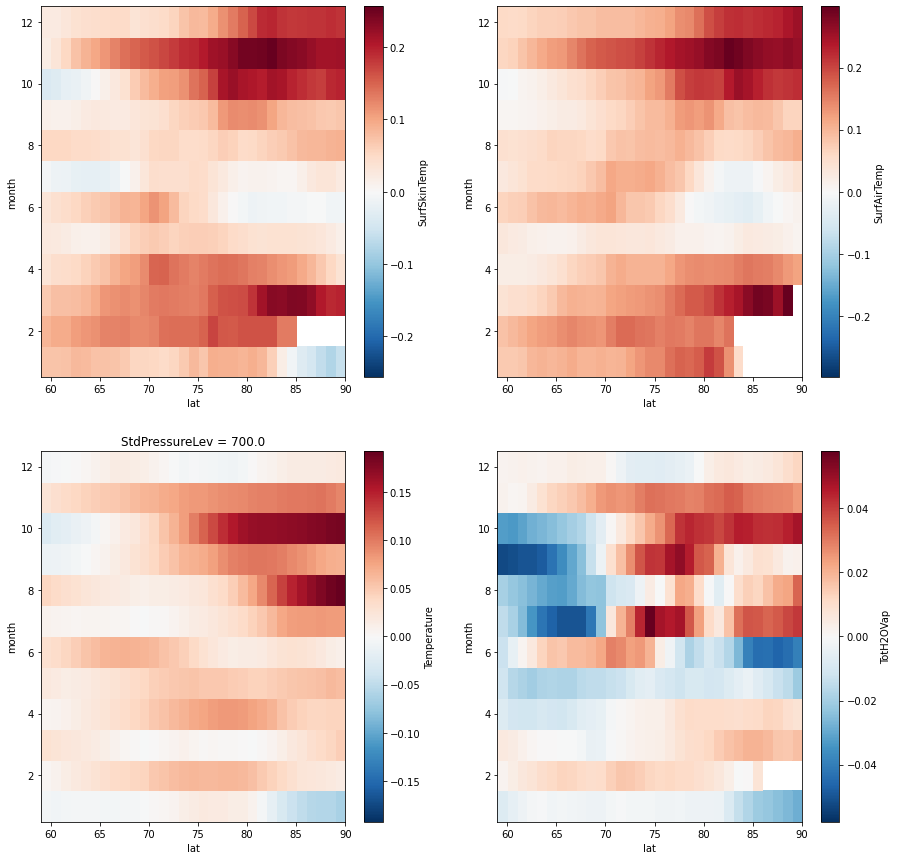

In [24]:
comp_fig,comp_axs = plt.subplots(2,2,figsize=(15,15))

comp_axs = comp_axs.flat

skintemp_trends.plot(ax=comp_axs[0])
airtemp_trends.plot(ax=comp_axs[1])
temp_700mb_trends.plot(ax=comp_axs[2])
wv_trends.plot(ax=comp_axs[3])

## Select most representative spectral channels

#### Reorder trends for plotting and spatial correlation

In [25]:
trends_reorg = all_data_spec_olr['TREND'].transpose('wnum','month','lat')
trends_clr_reorg = all_data_spec_olr_clr['TREND'].transpose('wnum','month','lat')

In [26]:
statsig_reorg = all_data_spec_olr['STATSIG'].transpose('wnum','month','lat')
statsig_clr_reorg = all_data_spec_olr_clr['STATSIG'].transpose('wnum','month','lat')

### Surface Skin Temperature

In [27]:
def tick_function(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

In [28]:
skintemp_interpd = skintemp_trends.interp_like(all_data_spec_olr_clr['TREND'])

In [29]:
rvals_skintemp = {}
rvals_list_skintemp =[]

rvals_skintemp_clr = {}
rvals_list_skintemp_clr =[]

for _wnum,_wnum_clr in zip(trends_reorg,trends_clr_reorg):
    
    r = calculate_spatial_correlation(_wnum,skintemp_interpd)
    r_clr = calculate_spatial_correlation(_wnum_clr,skintemp_interpd)
    
    rvals_skintemp[str(_wnum.wnum.values)] = r
    rvals_list_skintemp.append(r)
    
    rvals_skintemp_clr[str(_wnum.wnum.values)] = r_clr
    rvals_list_skintemp_clr.append(r_clr)


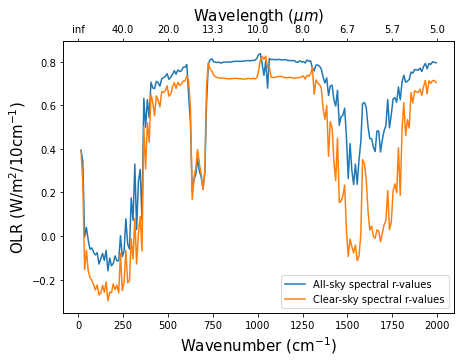

In [30]:
fig1 = plt.figure(constrained_layout=False,figsize=(7,5))
f1_ax1 = fig1.add_subplot(111)

f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_skintemp),label='All-sky spectral r-values')
f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_skintemp_clr),label='Clear-sky spectral r-values')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

f1_ax1b.set_xticks(ax2Ticks)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1b.set_xticklabels(tick_function(ax2Ticks))

f1_ax1b.set_xlabel('Wavelength ($\mu m$)',fontsize=15) # W/m$^{2}$/10cm$^{-1}$
f1_ax1.set_ylabel('r-value',fontsize=15)
f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=15)

f1_ax1.legend()

In [31]:
Keymax = max(zip(rvals_skintemp.values(), rvals_skintemp.keys()))#[1]
print(Keymax)

(0.837083282318675, '1015.0')


In [32]:
Keymax = max(zip(rvals_skintemp_clr.values(), rvals_skintemp_clr.keys()))#[1]
print(Keymax)

(0.825607289582091, '1045.0')


In [33]:
trends_1015_all = trends_reorg.sel(wnum=1015)
statsig_1015_all = statsig_reorg.sel(wnum=1015)

### 700 mb air temperature

In [34]:
temp_700mb_interpd = temp_700mb_trends.interp_like(all_data_spec_olr_clr['TREND'])

In [35]:
rvals_temp_700mb = {}
rvals_list_temp_700mb =[]

rvals_temp_700mb_clr = {}
rvals_list_temp_700mb_clr =[]

for _wnum,_wnum_clr in zip(trends_reorg,trends_clr_reorg):
    
    r = calculate_spatial_correlation(_wnum,temp_700mb_interpd)
    r_clr = calculate_spatial_correlation(_wnum_clr,temp_700mb_interpd)
    
    rvals_temp_700mb[str(_wnum.wnum.values)] = r
    rvals_list_temp_700mb.append(r)
    
    rvals_temp_700mb_clr[str(_wnum.wnum.values)] = r_clr
    rvals_list_temp_700mb_clr.append(r_clr)


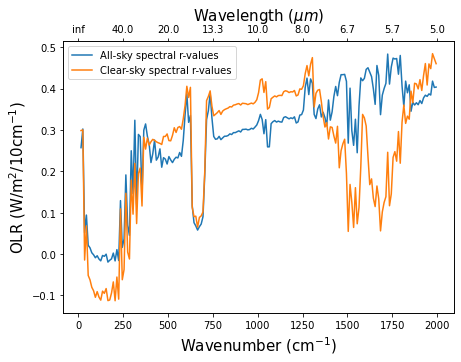

In [36]:
fig1 = plt.figure(constrained_layout=False,figsize=(7,5))
f1_ax1 = fig1.add_subplot(111)

f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_temp_700mb),label='All-sky spectral r-values')
f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_temp_700mb_clr),label='Clear-sky spectral r-values')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

f1_ax1b.set_xticks(ax2Ticks)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1b.set_xticklabels(tick_function(ax2Ticks))

f1_ax1b.set_xlabel('Wavelength ($\mu m$)',fontsize=15) # W/m$^{2}$/10cm$^{-1}$
f1_ax1.set_ylabel('r-value',fontsize=15)
f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=15)

f1_ax1.legend()

There is some interesting structure here, especially in the 1200-2000cm-1 region where there appears to be somewhat of a trade-off between all-sky and clear-sky.

In [37]:
Keymax = max(zip(rvals_temp_700mb.values(), rvals_temp_700mb.keys()))#[1]
print(Keymax)

(0.48319116857046474, '1725.0')


In [38]:
Keymax = max(zip(rvals_temp_700mb_clr.values(), rvals_temp_700mb_clr.keys()))#[1]
print(Keymax)

(0.4842123900876922, '1975.0')


In [39]:
trends_1725_all = trends_reorg.sel(wnum=1725)
statsig_1725_all = statsig_reorg.sel(wnum=1725)

### Column water vapor

In [40]:
wv_interpd = wv_trends.interp_like(all_data_spec_olr_clr['TREND'])

In [41]:
rvals_wv = {}
rvals_list_wv =[]

rvals_wv_clr = {}
rvals_list_wv_clr =[]

for _wnum,_wnum_clr in zip(trends_reorg,trends_clr_reorg):
    
    r = calculate_spatial_correlation(_wnum,wv_interpd)
    r_clr = calculate_spatial_correlation(_wnum_clr,wv_interpd)
    
    rvals_wv[str(_wnum.wnum.values)] = r
    rvals_list_wv.append(r)
    
    rvals_wv_clr[str(_wnum.wnum.values)] = r_clr
    rvals_list_wv_clr.append(r_clr)


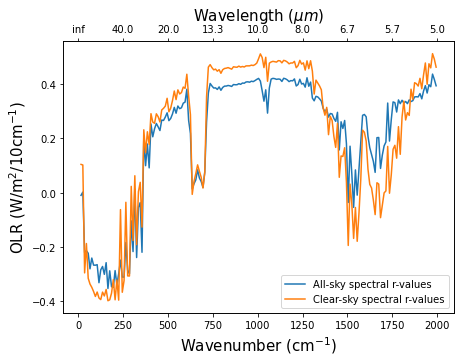

In [42]:
fig1 = plt.figure(constrained_layout=False,figsize=(7,5))
f1_ax1 = fig1.add_subplot(111)

f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_wv),label='All-sky spectral r-values')
f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_wv_clr),label='Clear-sky spectral r-values')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

f1_ax1b.set_xticks(ax2Ticks)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1b.set_xticklabels(tick_function(ax2Ticks))

f1_ax1b.set_xlabel('Wavelength ($\mu m$)',fontsize=15) # W/m$^{2}$/10cm$^{-1}$
f1_ax1.set_ylabel('r-value',fontsize=15)
f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=15)

f1_ax1.legend()

This is similar to the 700mb temperature but there is no tradeoff in the 1200-2000 cm-1 region. There is a clear advantage of using clear-sky values as well.

In [43]:
Keymax = max(zip(rvals_wv.values(), rvals_wv.keys()))#[1]
print(Keymax)

(0.43613376498977185, '1975.0')


In [44]:
Keymax = max(zip(rvals_wv_clr.values(), rvals_wv_clr.keys()))#[1]
print(Keymax)

(0.5113526280599303, '1975.0')


In [45]:
trends_1975_clr = trends_clr_reorg.sel(wnum=1975)
statsig_1975_clr = statsig_clr_reorg.sel(wnum=1975)

## Plot all-sky correlations (suggested by Jen)

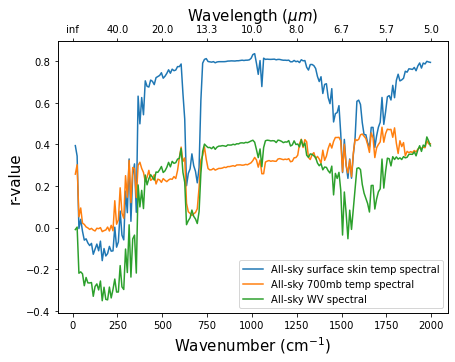

In [49]:
sumfig = plt.figure(constrained_layout=False,figsize=(7,5))
f1_ax1 = sumfig.add_subplot(111)

f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_skintemp),label='All-sky surface skin temp spectral')
f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_temp_700mb),label='All-sky 700mb temp spectral')
f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_wv),label='All-sky WV spectral')
# f1_ax1.plot(trends_reorg.wnum,np.array(rvals_list_wv_clr),label='Clear-sky spectral r-values')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

f1_ax1b.set_xticks(ax2Ticks)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1b.set_xticklabels(tick_function(ax2Ticks))

f1_ax1b.set_xlabel('Wavelength ($\mu m$)',fontsize=15) # W/m$^{2}$/10cm$^{-1}$
f1_ax1.set_ylabel('r-value',fontsize=15)
f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=15)

f1_ax1.legend()

## Plot summary data

#### Wrap data for better visualization

In [24]:
skintemp_trends_wrapped = xr.concat([skintemp_trends,skintemp_trends[0].assign_coords({'month':13})],dim='month')
skintemp_statsig_wrapped = xr.concat([skintemp_statsig,skintemp_statsig[0].assign_coords({'month':13})],dim='month')

airtemp_trends_wrapped = xr.concat([airtemp_trends,airtemp_trends[0].assign_coords({'month':13})],dim='month')
airtemp_statsig_wrapped = xr.concat([airtemp_statsig,airtemp_statsig[0].assign_coords({'month':13})],dim='month')

temp_700mb_trends_wrapped = xr.concat([temp_700mb_trends,temp_700mb_trends[0].assign_coords({'month':13})],dim='month')
temp_700mb_statsig_wrapped = xr.concat([temp_700mb_statsig,temp_700mb_statsig[0].assign_coords({'month':13})],dim='month')

wv_trends_wrapped = xr.concat([wv_trends,wv_trends[0].assign_coords({'month':13})],dim='month')
wv_statsig_wrapped = xr.concat([wv_statsig,wv_statsig[0].assign_coords({'month':13})],dim='month')

In [34]:
trends_1015_all_wrapped = xr.concat([trends_1015_all,trends_1015_all[0].assign_coords({'month':13})],dim='month')
statsig_1015_all_wrapped = xr.concat([statsig_1015_all,statsig_1015_all[0].assign_coords({'month':13})],dim='month')

trends_1725_all_wrapped = xr.concat([trends_1725_all,trends_1725_all[0].assign_coords({'month':13})],dim='month')
statsig_1725_all_wrapped = xr.concat([statsig_1725_all,statsig_1725_all[0].assign_coords({'month':13})],dim='month')

trends_1975_clr_wrapped = xr.concat([trends_1975_clr,trends_1975_clr[0].assign_coords({'month':13})],dim='month')
statsig_1975_clr_wrapped = xr.concat([statsig_1975_clr,statsig_1975_clr[0].assign_coords({'month':13})],dim='month')

Text(0.5, 0.95, 'Selected Trends and Spectral Counterparts')

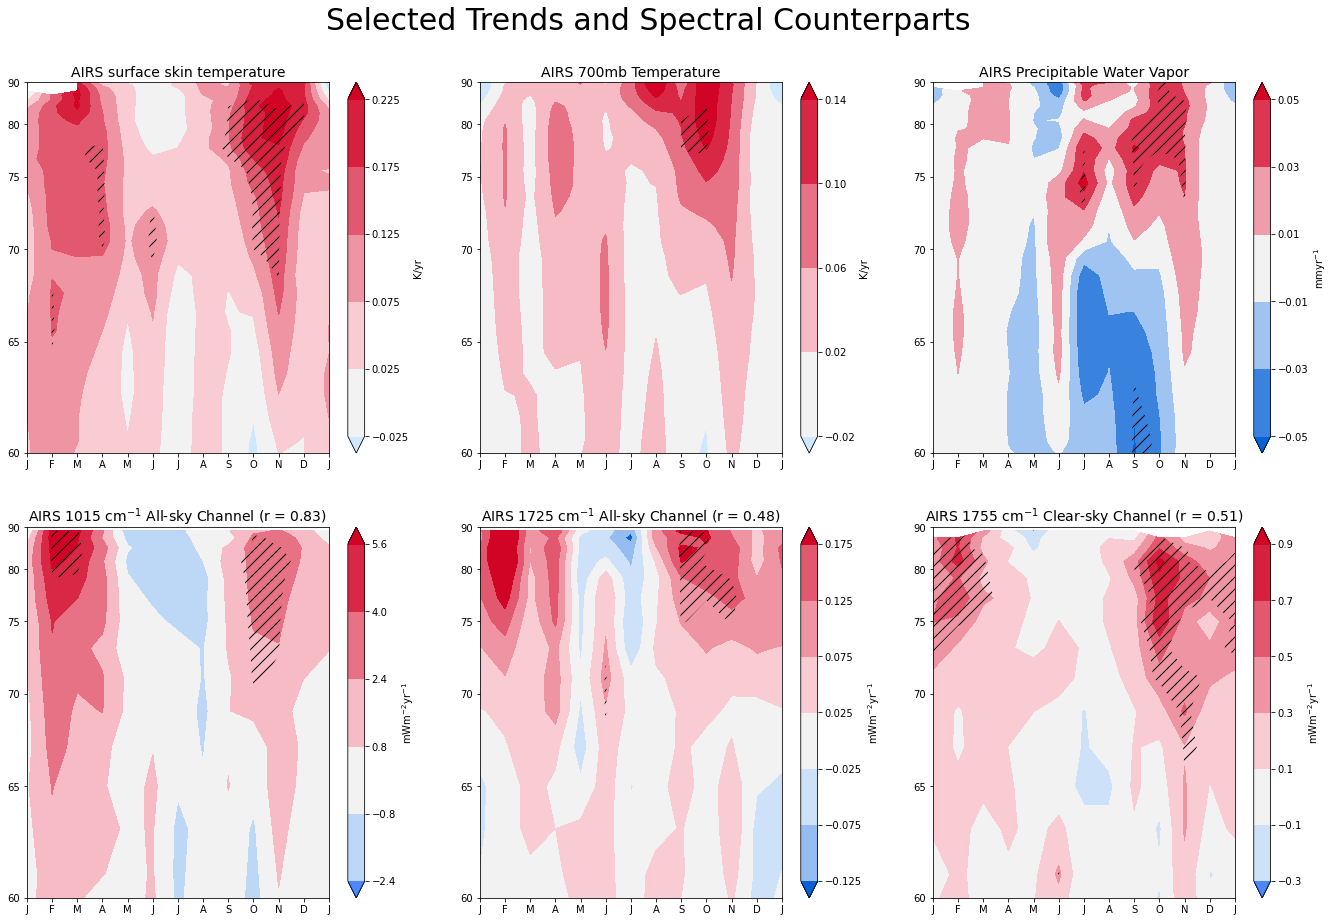

In [76]:
fig1,axs = plt.subplots(nrows=2,ncols=3,figsize=(23,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=30, n=9, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*skintemp_trends_wrapped['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(skintemp_trends_wrapped['month'],lat_weighted0,skintemp_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=cmap0,extend='both',vmin=-0.225,vmax=0.225,levels=np.arange(-0.025,0.226,0.05))
#                        cmap=cmap0,extend='both',vmin=-0.26,vmax=0.26,levels=np.arange(-0.06,0.261,0.04))
im0.cmap.set_under((0.81,0.91,1.00)) # im1.cmap.set_under((0.51,0.66,0.9))
stip = axes[0].contourf(skintemp_statsig_wrapped['month'],lat_weighted0,skintemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('AIRS surface skin temperature',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='K/yr')

lat_weighted1 = np.sin(np.pi/180*temp_700mb_trends_wrapped['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(temp_700mb_trends_wrapped['month'],lat_weighted1,temp_700mb_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=cmap1,extend='both',vmin=-0.14, vmax=0.14,levels=np.arange(-0.02,0.141,0.04))
#                        cmap=cmap1,extend='both',vmin=-0.165, vmax=0.165,levels=np.arange(-0.045,0.1651,0.03))
im1.cmap.set_under((0.81,0.91,1.00)) # im1.cmap.set_under('cornflowerblue')
stip = axes[1].contourf(temp_700mb_statsig_wrapped['month'],lat_weighted1,temp_700mb_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('AIRS 700mb Temperature',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*wv_trends_wrapped['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(wv_trends_wrapped['month'],lat_weighted2,wv_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=cmap2,extend='both',vmin=-0.05, vmax=0.05,levels=np.arange(-0.05,0.051,0.02))
# im2.cmap.set_under('cornflowerblue') # (0.81,0.91,1.00)
stip = axes[2].contourf(wv_statsig_wrapped['month'],lat_weighted2,wv_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('AIRS Precipitable Water Vapor',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='mmyr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*trends_1015_all_wrapped['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(trends_1015_all_wrapped['month'],lat_weighted3,1e3*trends_1015_all_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap3,extend='both',vmin=-5.6, vmax=5.6,levels=np.arange(-2.4,5.61,1.6))
im3.cmap.set_under((0.30,0.53,1.00)) # rgb(0.30,0.65,1.00)
stip = axes[3].contourf(statsig_1015_all_wrapped['month'],lat_weighted3,statsig_1015_all_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('AIRS 1015 cm$^{-1}$ All-sky Channel (r = 0.83)',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='mWm$^{-2}$yr$^{-1}$')

lat_weighted4 = np.sin(np.pi/180*trends_1725_all_wrapped['lat'])
cmap4 = copy.copy(palette)
im4 = axes[4].contourf(trends_1725_all_wrapped['month'],lat_weighted4,1e3*trends_1725_all_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap4,extend='both',vmin=-0.225,vmax=0.225,levels=np.arange(-0.125,0.225,0.05))
# im4.cmap.set_under((0.81,0.91,1.00))
stip = axes[4].contourf(statsig_1725_all_wrapped['month'],lat_weighted4,statsig_1725_all_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[4].set_title('AIRS 1725 cm$^{-1}$ All-sky Channel (r = 0.48)',fontsize=14)
plt.colorbar(im4,ax=axes[4],label='mWm$^{-2}$yr$^{-1}$')

lat_weighted5 = np.sin(np.pi/180*trends_1975_clr_wrapped['lat'])
cmap5 = copy.copy(palette)
im5 = axes[5].contourf(trends_1975_clr_wrapped['month'],lat_weighted5,1e3*trends_1975_clr_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap5,extend='both',vmin=-0.9,vmax=0.9,levels=np.arange(-0.3,0.91,0.2))
im5.cmap.set_under((0.30,0.53,1.00))
stip = axes[5].contourf(statsig_1975_clr_wrapped['month'],lat_weighted5,statsig_1975_clr_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[5].set_title('AIRS 1755 cm$^{-1}$ Clear-sky Channel (r = 0.51)',fontsize=14)
plt.colorbar(im5,ax=axes[5],label='mWm$^{-2}$yr$^{-1}$')

fig1.suptitle('Selected Trends and Spectral Counterparts',fontsize=30,y=0.95)